In [1]:
import numpy as np
import pandas as pd

# Cleaned Data

In [2]:
airbnb = pd.read_csv('data/airbnb.csv', low_memory=False)

In [3]:
relevantCols = ['amenities', 'first_review', 'host_neighbourhood', 
            'last_review', 'neighbourhood_cleansed', 'nightly_price', 
            'price_per_stay', 'property_type', 'review_scores_rating', 
            'room_type', 'number_of_reviews']

airbnb = airbnb[relevantCols]

In [4]:
airbnb.amenities = airbnb.amenities.str.slice(1,-1).str.replace('"', '').str.split(',')

In [5]:
airbnb.first_review = pd.to_datetime(airbnb.first_review.str.replace('/','-'))
airbnb.last_review = pd.to_datetime(airbnb.last_review.str.replace('/','-'))

/var/folders/gf/251f82hj37z24mwyzsz3m4500000gn/T/ipykernel_16084/24953350.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  airbnb.first_review = pd.to_datetime(airbnb.first_review.str.replace('/','-'))
/var/folders/gf/251f82hj37z24mwyzsz3m4500000gn/T/ipykernel_16084/24953350.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  airbnb.last_review = pd.to_datetime(airbnb.last_review.str.replace('/','-'))


In [6]:
airbnb.nightly_price = (airbnb.nightly_price.str.slice(1)
                    .str.strip().str.replace(',', ''))
airbnb.nightly_price = airbnb.nightly_price.replace('', np.NaN).astype(float)
airbnb.price_per_stay = (airbnb.price_per_stay.str.slice(1)
                    .str.strip().str.replace(',', ''))
airbnb.price_per_stay = airbnb.price_per_stay.replace('', np.NaN).astype(float)

In [7]:
# number of days of reviews since first review
airbnb['days_of_reviews'] = (airbnb.last_review - airbnb.first_review).dt.days
# number of amenities
airbnb['num_amenities'] = airbnb.amenities.str.len()

In [8]:
airbnb = airbnb.dropna()
airbnb.head()

,amenities,first_review,host_neighbourhood,last_review,neighbourhood_cleansed,nightly_price,price_per_stay,property_type,review_scores_rating,room_type,number_of_reviews,days_of_reviews,num_amenities
1,"[TV, Wifi, Air conditioning, Kitchen, Free par...",2017-04-22,La Jolla,2017-08-31,La Jolla,1400.0,1400.0,Apartment,100.0,Entire home/apt,2.0,131.0,21.0
4,"[TV, Wifi, Kitchen, Free parking on premises, ...",2015-02-22,La Jolla,2018-09-23,La Jolla,110.0,110.0,Condominium,90.0,Private room,2.0,1309.0,11.0
10,"[TV, Cable TV, Internet, Wifi, Air conditionin...",2016-10-10,Black Mountain Ranch,2017-05-27,Rancho Penasquitos,75.0,75.0,Bungalow,93.0,Entire home/apt,3.0,229.0,34.0
12,"[TV, Internet, Wifi, Kitchen, Free parking on ...",2015-11-19,Pacific Beach,2018-07-02,Mission Bay,75.0,4500.0,House,100.0,Private room,27.0,956.0,37.0
13,"[TV, Wifi, Pool, Kitchen, Free parking on prem...",2016-02-21,Pacific Beach,2019-05-12,Pacific Beach,65.0,3900.0,Condominium,97.0,Entire home/apt,12.0,1176.0,32.0


# T-tests, Linear Regression

In [58]:
import scipy.stats as stats
import matplotlib.pyplot as plt

In [59]:
(airbnb.groupby('property_type')['review_scores_rating']
.mean() 
).head()

property_type
Aparthotel           96.142857
Apartment            94.278278
Bed and breakfast    93.764706
Boat                 97.708333
Boutique hotel       91.294118
Name: review_scores_rating, dtype: float64

In [60]:
(airbnb.property_type
.value_counts()).head()


property_type
House          3251
Apartment      2555
Condominium    1246
Townhouse       488
Guesthouse      387
Name: count, dtype: int64

In [61]:
(airbnb.groupby('property_type')['review_scores_rating']
.mean() / 
airbnb.property_type
.value_counts()
).head()

property_type
Aparthotel           13.734694
Apartment             0.036900
Bed and breakfast     5.515571
Boat                  4.071181
Boutique hotel        5.370242
dtype: float64

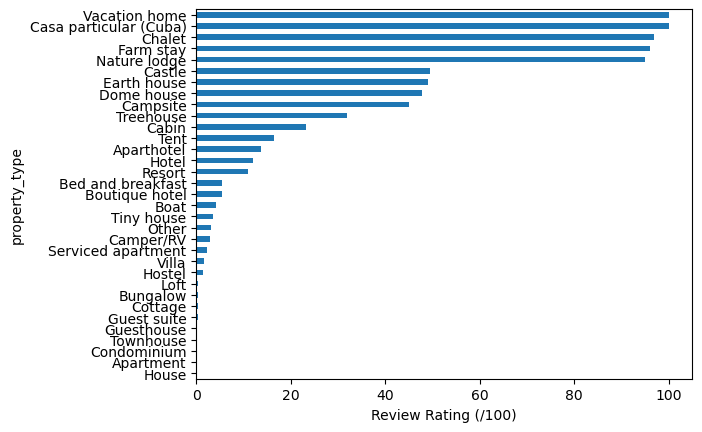

In [51]:
(
(airbnb.groupby('property_type')['review_scores_rating']
.mean() / 
airbnb.property_type
.value_counts()
)
.sort_values(ascending=True)

.plot.barh()
)
plt.xlabel('Review Rating (/100)')
plt.show()

In [76]:
import statsmodels.formula.api as smf
full_model_formula = f' review_scores_rating ~ {"+".join(airbnb.columns.drop(["review_scores_rating", "amenities"]))}'

elastic_fit = smf.ols(full_model_formula, data=airbnb).\
                fit_regularized(method='elastic_net', alpha=1.0, L1_wt=1.0)

print(elastic_fit.params)

Intercept                                           85.257946
first_review[T.Timestamp('2010-07-20 00:00:00')]     0.000000
first_review[T.Timestamp('2010-09-09 00:00:00')]     0.000000
first_review[T.Timestamp('2010-12-05 00:00:00')]     0.000000
first_review[T.Timestamp('2011-01-04 00:00:00')]     0.000000
                                                      ...    
nightly_price                                        0.001403
price_per_stay                                       0.000613
number_of_reviews                                    0.008015
days_of_reviews                                      0.000550
num_amenities                                        0.259691
Length: 3200, dtype: float64


In [75]:
final_params = elastic_fit.params[elastic_fit.params != 0].index[1:]
print(final_params)

print(smf.ols( f'review_scores_rating ~ {"+".join(final_params)}', airbnb).fit().summary())

Index(['nightly_price', 'price_per_stay', 'number_of_reviews',
       'days_of_reviews', 'num_amenities'],
      dtype='object')
                             OLS Regression Results                             
Dep. Variable:     review_scores_rating   R-squared:                       0.020
Model:                              OLS   Adj. R-squared:                  0.019
Method:                   Least Squares   F-statistic:                     37.75
Date:                  Sat, 01 Jun 2024   Prob (F-statistic):           1.80e-38
Time:                          10:54:29   Log-Likelihood:                -31424.
No. Observations:                  9372   AIC:                         6.286e+04
Df Residuals:                      9366   BIC:                         6.290e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                        coef    std err          t      P>|t|

In [77]:
def decision(pvalue, alpha):
    if pvalue < alpha:
        print(f'reject H0: pvalue={pvalue} < {alpha}')  
    else: 
        print(f'fail to reject H0: pvalue={pvalue} ≥ {alpha}')
alpha = 0.01
tstat, pvalue = stats.chisquare(f_obs=airbnb['neighbourhood_cleansed'].value_counts())
decision(pvalue, alpha)

reject H0: pvalue=0.0 < 0.01
